In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

In [ ]:
import zipfile

with zipfile.ZipFile('kuzushiji.zip', 'r') as zip_ref:
    zip_ref.extractall('kuzushiji_dataset')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds

dataset, info = tfds.load('kmnist', with_info=True, as_supervised=True)

full_dataset = dataset['train']

def preprocess_data(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

images, labels = preprocess_data(full_dataset)

# Normalize images to range [0, 1]
images = images.reshape(-1, 28*28) / 255.0

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.Z281OU_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.Z281OU_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.
Training set shape: (48000, 784), Training labels shape: (48000,)
Test set shape: (12000, 784), Test labels shape: (12000,)


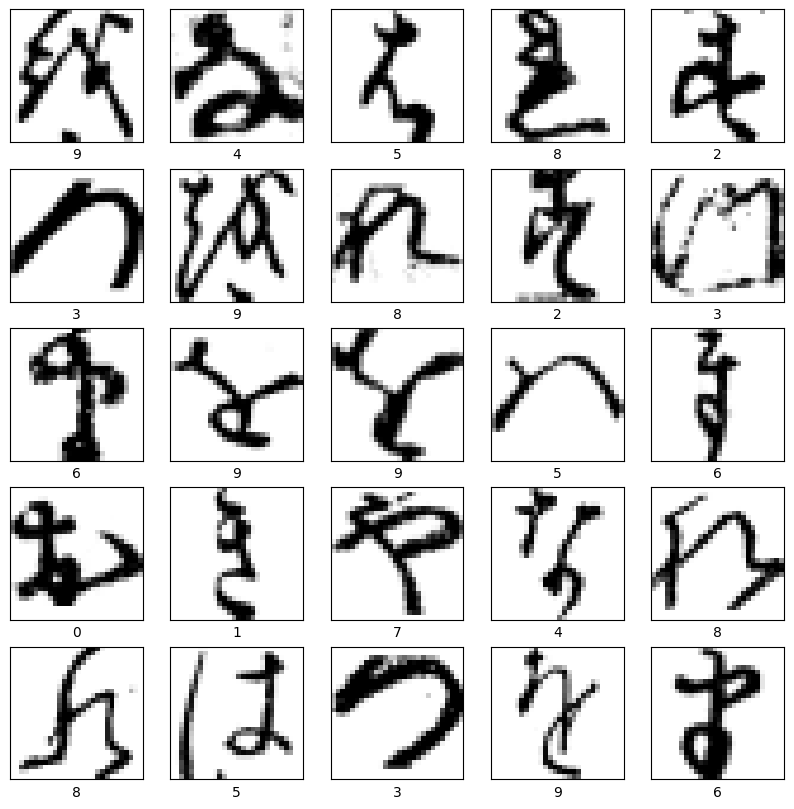

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [ ]:
print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[0.         0.         0.         ... 0.27843137 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.43529412 0.30588235 0.        ]]
[9 4 5 ... 6 1 9]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[3 8 3 ... 3 8 7]


In [ ]:
def rbf(x, center, sigma=1.0):
    return np.exp(-np.linalg.norm(x - center) ** 2 / (2 * sigma ** 2))

class RBFNetwork:
    def __init__(self, num_rbf_units, num_classes):
        self.num_rbf_units = num_rbf_units
        self.num_classes = num_classes
        self.centers = None
        self.weights = None
        self.sigma = None

    def fit(self, X, y, learning_rate=0.01, epochs=100):
        kmeans = KMeans(n_clusters=self.num_rbf_units)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Random weights
        self.weights = np.random.randn(self.num_rbf_units, self.num_classes)

        # Using mean distance between centers as sigma
        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.sigma = d_max / np.sqrt(2 * self.num_rbf_units)

        # One-hot encode labels
        y_one_hot = np.eye(self.num_classes)[y]

        # Training loop
        for epoch in range(epochs):
            # Compute RBF activations for each input
            G = np.zeros((X.shape[0], self.num_rbf_units))
            for i, x in enumerate(X):
                for j, c in enumerate(self.centers):
                    G[i, j] = rbf(x, c, self.sigma)

            # Forward pass (softmax)
            output = self.softmax(np.dot(G, self.weights))

            # Backpropagation (gradient descent)
            error = output - y_one_hot
            self.weights -= learning_rate * np.dot(G.T, error)

            loss = np.mean(np.square(error))
            print(f'Epoch {epoch}\n\tLoss: {loss}')

    # Predict function
    def predict(self, X):
        G = np.zeros((X.shape[0], self.num_rbf_units))
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                G[i, j] = rbf(x, c, self.sigma)

        output = self.softmax(np.dot(G, self.weights))
        return np.argmax(output, axis=1)

    # Softmax function
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [ ]:

# Instantiate the RBF Network
num_rbf_units = 100
num_classes = 10
rbf_network = RBFNetwork(num_rbf_units=num_rbf_units, num_classes=num_classes)

# Train the model
rbf_network.fit(X_train, y_train, learning_rate=0.01, epochs=100)

Epoch 0
	Loss: 0.09000000711304851
Epoch 1
	Loss: 0.0900000071103332
Epoch 2
	Loss: 0.09000000710761787
Epoch 3
	Loss: 0.09000000710490257
Epoch 4
	Loss: 0.09000000710218724
Epoch 5
	Loss: 0.0900000070994719
Epoch 6
	Loss: 0.09000000709675655
Epoch 7
	Loss: 0.09000000709404123
Epoch 8
	Loss: 0.0900000070913259
Epoch 9
	Loss: 0.0900000070886106
Epoch 10
	Loss: 0.09000000708589526
Epoch 11
	Loss: 0.09000000708317993
Epoch 12
	Loss: 0.09000000708046463
Epoch 13
	Loss: 0.09000000707774923
Epoch 14
	Loss: 0.09000000707503389
Epoch 15
	Loss: 0.09000000707231862
Epoch 16
	Loss: 0.09000000706960326
Epoch 17
	Loss: 0.09000000706688793
Epoch 18
	Loss: 0.09000000706417262
Epoch 19
	Loss: 0.09000000706145725
Epoch 20
	Loss: 0.09000000705874195
Epoch 21
	Loss: 0.09000000705602659
Epoch 22
	Loss: 0.09000000705331125
Epoch 23
	Loss: 0.09000000705059592
Epoch 24
	Loss: 0.0900000070478806
Epoch 25
	Loss: 0.09000000704516523
Epoch 26
	Loss: 0.09000000704244991
Epoch 27
	Loss: 0.09000000703973457
Epoch 2

Accuracy: 0.10575%


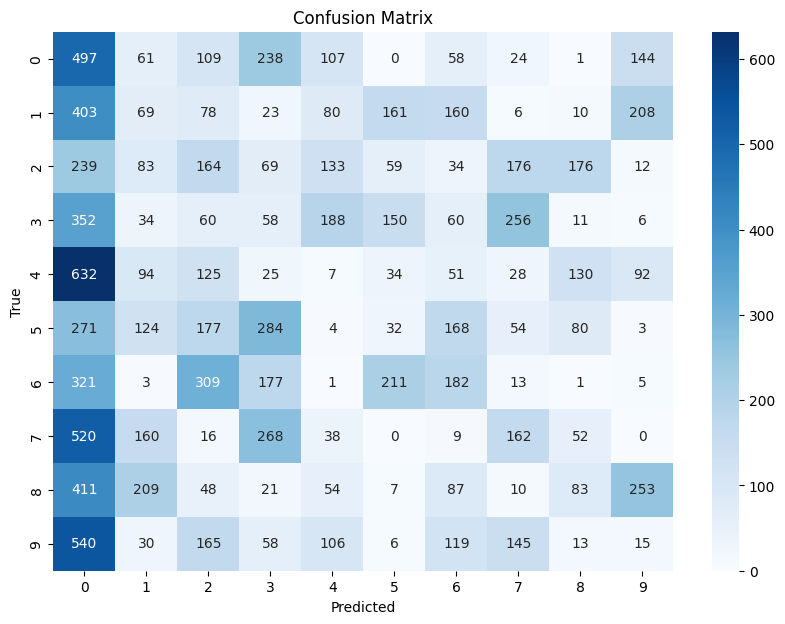

In [ ]:
y_pred = rbf_network.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Precision: 0.09881699877553746
Recall: 0.10575
F1-score: 0.09151991216300033


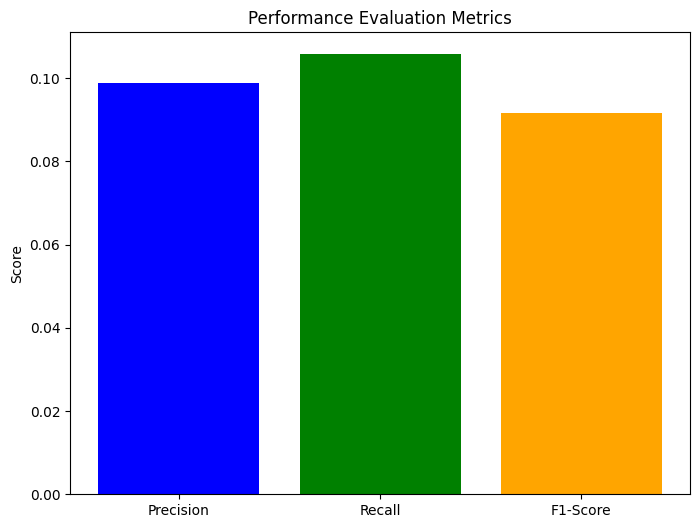

In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.title('Performance Evaluation Metrics')
plt.ylabel('Score')
plt.show()




**Strengths of RBF Networks:**

* **Nonlinearity:** RBF networks are inherently nonlinear, capable of capturing complex relationships within the image data. This is particularly advantageous for the KMNIST dataset, which consists of handwritten characters with various styles and variations.
* **Local Sensitivity:** RBF units are localized, meaning they respond strongly to specific input regions or features. This property allows the network to identify patterns and variations in different parts of the characters effectively.
* **Good for Pattern Recognition:** RBF networks excel at tasks like pattern recognition and classification, making them a suitable choice for the character recognition task presented in KMNIST.
* **Relatively Simple Architecture:** Compared to deep learning models, RBF networks have a simpler architecture, which can lead to faster training times, particularly for smaller datasets.

**Limitations of RBF Networks:**

* **Sensitivity to Center Selection:** The performance of an RBF network heavily depends on the selection of RBF unit centers. Poor center selection can lead to suboptimal performance and limited ability to capture the data's complexity. The K-Means approach used in the provided code can be sensitive to the initial cluster assignments.
* **Number of RBF Units:** Determining the optimal number of RBF units can be challenging. Too few units may lead to underfitting, while too many units can lead to overfitting and computational complexity.
* **Computational Cost:** While generally simpler than deep learning models, RBF networks can still be computationally expensive, particularly when dealing with a large number of RBF units or a high-dimensional input space like the image data in KMNIST.
* **Limited Expressiveness:** In complex tasks with significant variations, RBF networks may struggle to capture highly intricate patterns compared to deep learning models with multiple layers.



**How Number of RBF Units Affects Model Performance:**

* **Too Few Units (Underfitting):** If the number of RBF units is too small, the model may not have enough capacity to represent the complexities of the data. This leads to underfitting, where the model fails to capture the underlying patterns, resulting in poor accuracy and generalization.
* **Optimal Number of Units:** There exists an optimal number of RBF units that balances model complexity and data representation. This usually leads to the best accuracy on the training and testing sets.
* **Too Many Units (Overfitting):** An excessive number of RBF units can lead to overfitting, where the model memorizes the training data rather than learning generalizable patterns. This can result in excellent training accuracy but poor performance on unseen data (test data), as the model may fail to generalize well.


**In Summary:**

RBF networks are a viable choice for the dataset, particularly considering their capability to capture nonlinear relationships and local patterns within the image data. However, careful selection of the number of RBF units and center locations is crucial to ensure good model performance. Proper hyperparameter tuning and potentially employing advanced techniques for center selection can enhance the RBF network's ability to achieve good accuracy in the KMNIST character recognition task.


The provided code uses K-Means for center selection and demonstrates the impact of the number of RBF units on the model's performance. By experimenting with different numbers of RBF units, you can analyze the trade-off between model complexity and performance and find the best configuration for the given KMNIST dataset.